#### Aluno: Victor Gabriel Tenório Oliveira
---
projeto2VA_redes_neurais

# Configuração inicial

In [ ]:
!pip install minisom --quiet
!pip install pytz --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from datetime import datetime
from minisom import MiniSom
from PIL import Image
import numpy as np
import itertools
import pytz
import csv
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

tz = pytz.timezone('America/Recife')

ACCURACY_THRESHOLD = 80.0

# para salvar métricas dos resultados no Drive
result_path = "/content/drive/MyDrive/Projeto de Redes Neurais/results.csv"
current_id_path = "/content/drive/MyDrive/Projeto de Redes Neurais/current_id.txt"
metrics_log_path = "/content/drive/MyDrive/Projeto de Redes Neurais/metrics_log.txt"
saved_models_path = "/content/drive/MyDrive/Projeto de Redes Neurais/saved models"
# metrics_log_file = open(metrics_log_path, 'a')

# Troca aqui para treinar predizer conjunto de artefato ou raridade
# train_predict_artifact_set = True


# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cpu


In [ ]:
# Mostra todos os styles do matplotlib
# plt.style.available

In [ ]:
loss_functions = {
    'nn.L1Loss': {'loss function': nn.L1Loss, 'L1 lambda': 0.0},
    'nn.MSELoss': {'loss function': nn.MSELoss, 'L1 lambda': 0.0},
    'nn.CrossEntropyLoss': {'loss function': nn.CrossEntropyLoss, 'L1 lambda': 0.0},
    'nn.NLLLoss': {'loss function': nn.NLLLoss, 'L1 lambda': 0.0},
    'nn.HingeEmbeddingLoss': {'loss function': nn.HingeEmbeddingLoss, 'L1 lambda': 0.0},
    'nn.MarginRankinLoss': {'loss function': nn.MarginRankingLoss, 'L1 lambda': 0.0},
    'nn.TripleMarginLoss': {'loss function': nn.TripletMarginLoss, 'L1 lambda': 0.0},
    'nn.KLDivLoss': {'loss function': nn.KLDivLoss, 'L1 lambda': 0.0},
}

L1_lambda = 0.0001
L1_norm = lambda model: sum(p.abs().sum() for p in model.parameters())
loss_functions['with L1'] = {
    'nn.L1Loss': {'loss function': nn.L1Loss, 'L1 lambda': L1_lambda},
    'nn.MSELoss': {'loss function': nn.MSELoss, 'L1 lambda': L1_lambda},
    'nn.CrossEntropyLoss': {'loss function': nn.CrossEntropyLoss, 'L1 lambda': L1_lambda},
    'nn.NLLLoss': {'loss function': nn.NLLLoss, 'L1 lambda': L1_lambda},
    'nn.HingeEmbeddingLoss': {'loss function': nn.HingeEmbeddingLoss, 'L1 lambda': L1_lambda},
    'nn.MarginRankinLoss': {'loss function': nn.MarginRankingLoss, 'L1 lambda': L1_lambda},
    'nn.TripleMarginLoss': {'loss function': nn.TripletMarginLoss, 'L1 lambda': L1_lambda},
    'nn.KLDivLoss': {'loss function': nn.KLDivLoss, 'L1 lambda': L1_lambda},
}

optimizers = {
    'torch.optim.SGD': {'optimizer function': torch.optim.SGD, 'weight decay': 0.0},
    'torch.optim.Adam': {'optimizer function': torch.optim.Adam, 'weight decay': 0.0},
    'torch.optim.Adadelta': {'optimizer function': torch.optim.Adadelta, 'weight decay': 0.0},
    'torch.optim.Adagrad': {'optimizer function': torch.optim.Adagrad, 'weight decay': 0.0},
    'torch.optim.AdamW': {'optimizer function': torch.optim.AdamW, 'weight decay': 0.0},
    'torch.optim.SparseAdam': {'optimizer function': torch.optim.SparseAdam, 'weight decay': 0.0},
    'torch.optim.Adamax': {'optimizer function': torch.optim.Adamax, 'weight decay': 0.0},
    'torch.optim.ASGD': {'optimizer function': torch.optim.ASGD, 'weight decay': 0.0},
    'torch.optim.LBFGS': {'optimizer function': torch.optim.LBFGS, 'weight decay': 0.0},
    'torch.optim.RMSprop': {'optimizer function': torch.optim.RMSprop, 'weight decay': 0.0},
    'torch.optim.Rprop': {'optimizer function': torch.optim.Rprop, 'weight decay': 0.0}
}

weight_decay = 0.001
optimizers['with L2'] = {
    'torch.optim.SGD': {'optimizer function': torch.optim.SGD, 'weight decay': weight_decay},
    'torch.optim.Adam': {'optimizer function': torch.optim.Adam, 'weight decay': weight_decay},
    'torch.optim.Adadelta': {'optimizer function': torch.optim.Adadelta, 'weight decay': weight_decay},
    'torch.optim.Adagrad': {'optimizer function': torch.optim.Adagrad, 'weight decay': weight_decay},
    'torch.optim.AdamW': {'optimizer function': torch.optim.AdamW, 'weight decay': weight_decay},
    'torch.optim.SparseAdam': {'optimizer function': torch.optim.SparseAdam, 'weight decay': weight_decay},
    'torch.optim.Adamax': {'optimizer function': torch.optim.Adamax, 'weight decay': weight_decay},
    'torch.optim.ASGD': {'optimizer function': torch.optim.ASGD, 'weight decay': weight_decay},
    'torch.optim.LBFGS': {'optimizer function': torch.optim.LBFGS, 'weight decay': weight_decay},
    'torch.optim.RMSprop': {'optimizer function': torch.optim.RMSprop, 'weight decay': weight_decay},
    'torch.optim.Rprop': {'optimizer function': torch.optim.Rprop, 'weight decay': weight_decay}
}

# Parâmetros

In [ ]:
# Para o treinamento com dataset de conjunto de artefato
# esse ou mais épocas, 33, 34, 36, 40, 75
CNN_LEARNING_RATES = [3e-4] # [5e-3, 5e-4] [1e-3, 1e-4, 5e-5]
BATCH_SIZES = [101] # [50]
N_EPOCHS = [75]
CRITERIONS = [
    loss_functions['nn.CrossEntropyLoss'],
]
OPTIMIZERS = [
    optimizers['with L2']['torch.optim.RMSprop'],
]

SOM_LEARNING_RATES = [5e-1]
SOM_SIZES = [{'lines': 30, 'colums': 30}]
ITERATIONS = [303]
SIGMAS = [3]

# Todas as combinações de parâmetros de conjunto de artefato
params_cnn = list(itertools.product(
    CNN_LEARNING_RATES, BATCH_SIZES, N_EPOCHS, CRITERIONS, OPTIMIZERS
))
params_som = list(itertools.product(
    SOM_LEARNING_RATES, SOM_SIZES, ITERATIONS, SIGMAS
))

################################################################################

# Parâmetros para o treino com dataset de raridade de artefato
CNN_LEARNING_RATES_2 = [7.5e-5]
BATCH_SIZES_2 = [39]
N_EPOCHS_2 = [23]
CRITERIONS_2 = [
    loss_functions['with L1']['nn.CrossEntropyLoss'],
]
new_ewight_decay = 0.001
optimizers['with L2']['torch.optim.Adam']['weight decay'] = new_ewight_decay
OPTIMIZERS_2 = [
    # optimizers["torch.optim.Adam"],
    optimizers['with L2']['torch.optim.Adam'],
]

SOM_LEARNING_RATES_2 = [5e-1]
SOM_SIZES_2 = [{'lines': 30, 'colums': 30}]
ITERATIONS_2 = [335]
SIGMAS_2 = [2]

# Usados na parte de treinar com raridade de raridade de artefato
params_cnn_2 = list(itertools.product(
    CNN_LEARNING_RATES_2, BATCH_SIZES_2, N_EPOCHS_2, CRITERIONS_2, OPTIMIZERS_2
))
params_som_2 = list(itertools.product(
    SOM_LEARNING_RATES_2, SOM_SIZES_2, ITERATIONS_2, SIGMAS_2
))

# Dados úteis da imagem de treino
START_IMG_SIZE = {'height': 560, 'width': 328} # 189 x 328
CROP_SIZE = 371
RESIZE_FACTOR = 0.5
FINAL_IMG_SIZE = {
    'height': int((START_IMG_SIZE['height'] - CROP_SIZE) * RESIZE_FACTOR),
    'width':  int(START_IMG_SIZE['width'] * RESIZE_FACTOR)
}

# Number of target classes
RARITY_N = 2
ARTIFACT_SET_N = 40

---
# Definição das Redes
- SOM (Implementação da biblioteca Mini Som)
- VGG-mini
<!-- - CustomCNN -->

### VGG-mini

In [ ]:
class VGG_mini(nn.Module):

    def __init__(self, n_classes):
        super(VGG_mini, self).__init__()

        # Maxpool 2x2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv layers with batch norm
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding = 1)
        self.norm1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 64, 3, padding = 1)
        self.norm2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        self.norm3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, 3, padding = 1)
        self.norm4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.norm5 = nn.BatchNorm2d(256)

        self.conv6 = nn.Conv2d(256, 256, 3, padding = 1)
        self.norm6 = nn.BatchNorm2d(256)

        self.conv7 = nn.Conv2d(256, 512, 3, padding = 1)
        self.norm7 = nn.BatchNorm2d(512)

        self.conv8 = nn.Conv2d(512, 512, 3, padding = 1)
        self.norm8 = nn.BatchNorm2d(512)

        # fully connected layer with batch norm
        # Caso tamanho original -> 189 x 328 -> 94 x 82 -> 23 x 41 -> 11 x 20 -> 512 * 11 * 20 = 112640 elements
        # self.fc1 = nn.Linear(in_features = 112640, out_features = 128)
        self.fc1 = nn.Linear(in_features = 512 * 5 * 10, out_features = 128)
        self.norm9 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 64)
        self.norm10 = nn.BatchNorm1d(64)

        self.fc3 = nn.Linear(64, n_classes)


    def forward(self, x):
        # Para o caso de batch_size = 1

        # x.size() -> [1(batch_size), 1(grayscale/input_channels), 94(height), 164(width)]
        # 1 * 1 * 94 * 164 -> 15416 matrix elements -> pixels of input image
        out = F.elu(self.norm1(self.conv1(x)))   # out.size() -> [1(batch_size), 64(out_channels), 94(padding), 164(padding)] -> 986624 * 1(batch_size)
        out = F.elu(self.norm2(self.conv2(out))) # out.size() -> [1(batch_size), 64(out_channels), 94(padding), 164(padding)] -> 986624 * 1(batch_size)
        out = self.pool(out)                     # out.size() -> [1(batch_size), 64(out_channels), 47(halfed) , 82(halfed)  ] -> 246656 * 1(batch_size)

        out = F.elu(self.norm3(self.conv3(out))) # out.size() -> [1(batch_size), 128(out_channels), 47(padding), 82(padding)] -> 493312 * 1(batch_size)
        out = F.elu(self.norm4(self.conv4(out))) # out.size() -> [1(batch_size), 128(out_channels), 47(padding), 82(padding)] -> 493312 * 1(batch_size)
        out = self.pool(out)                     # out.size() -> [1(batch_size), 128(out_channels), 23(halfed) , 41(halfed) ] -> 120704 * 1(batch_size)

        out = F.elu(self.norm5(self.conv5(out))) # out.size() -> [1(batch_size), 256(out_channels), 23(padding), 41(padding)] -> 241408 * 1(batch_size)
        out = F.elu(self.norm6(self.conv6(out))) # out.size() -> [1(batch_size), 256(out_channels), 23(padding), 41(padding)] -> 241408 * 1(batch_size)
        out = self.pool(out)                     # out.size() -> [1(batch_size), 256(out_channels), 11(halfed) , 20(halfed) ] -> 56320 * 1(batch_size)

        out = F.elu(self.norm7(self.conv7(out))) # out.size() -> [1(batch_size), 512(out_channels), 11(halfed) , 20(halfed) ] -> 112640 * 1(batch_size)
        out = F.elu(self.norm8(self.conv8(out))) # out.size() -> [1(batch_size), 512(out_channels), 11(halfed) , 20(halfed) ] -> 112640 * 1(batch_size)
        out = self.pool(out)                     # out.size() -> [1(batch_size), 512(out_channels), 5(halfed)  , 10(halfed) ] -> 25600 * 1(batch_size)

        out = out.view(-1, 512 * 5 * 10)         # out.size() -> [1(batch_size), 25600(number_of_elements/numel)] -> 25600 * 1(batch_size)
        # Caso tamanho original -> 189 x 328 -> 94 x 82 -> 23 x 41 -> 11 x 20 -> 512 * 11 * 20 = 112640 elements
        # out = out.view(-1, 112640)               # out.size() -> [1(batch_size), 25600(number_of_elements/numel)] -> 25600 * 1(batch_size)

        out = F.elu(self.norm9(self.fc1(out)))   # out.size() -> [1(batch_size), 128] -> 128 * 1(batch_size)
        out = F.elu(self.norm10(self.fc2(out)))  # out.size() -> [1(batch_size),  64] -> 64 * 1(batch_size)
        out = self.fc3(out)
        # temp = out
        probs = F.softmax(out, dim=1)            # out.size() -> [1(batch_size),  43(ARTIFACT_SET_N)] -> 64 * 1(batch_size)


        # print("+++++++++++++++++++++")
        # # print(temp)
        # print(temp.numel())
        # print(temp.size())
        # print(type(temp))
        # input(">>>")
        # print("+++++++++++++++++++++")

        return out, probs

### CustomCNN

In [ ]:
class Custom_CNN(nn.Module):

    def __init__(self, n_classes):
        super(Custom_CNN, self).__init__()

        # Avgpool 2x2 - Usada nas camadas 4 e 8
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.norm1 = nn.BatchNorm2d(num_features=32)
        # ReLU

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.norm2 = nn.BatchNorm2d(num_features=32)
        # ReLU

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.norm3 = nn.BatchNorm2d(num_features=32)
        # ReLU

        # Layer 4
        # avg pool

        # Layer 5
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.norm5 = nn.BatchNorm2d(num_features=64)
        # ReLU

        # Layer 6
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.norm6 = nn.BatchNorm2d(num_features=64)
        # ReLU

        # Layer 7
        self.conv7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.norm7 = nn.BatchNorm2d(num_features=64)
        # ReLU

        # Layer 8
        # avg pool

        # Layer 9
        self.fc9 = nn.Linear(in_features=64 * 23 * 41, out_features=128)
        # self.fc9 = nn.Linear(in_features=246656, out_features=128)
        self.norm9 = nn.BatchNorm1d(num_features=128)
        # ReLU

        # Layer 10
        self.fc10 = nn.Linear(in_features=128, out_features=64)
        self.norm10 = nn.BatchNorm1d(num_features=64)
        # ReLU

        # Layer 11
        self.fc11 = nn.Linear(in_features=64, out_features=n_classes)


    def forward(self, x):

        def print_tensor_info(tensor):
            print("+++++++++++++++++++++")
            # print(tensor)
            print(tensor.numel())
            print(tensor.size())
            print(type(tensor))
            input(">>>")
            print("+++++++++++++++++++++")

        # Para o caso de batch_size = 1
        # x.size() -> [1(batch_size), 1(grayscale/input_channels), 94(height), 164(width)]
        # 1 * 1 * 94 * 164 -> 15416 matrix elements -> pixels of input image

        out = F.relu(self.norm1(self.conv1(x)))   # out.size() -> [1(batch_size), 32(out_channels), 94(height/kernel/padding), 164(height/kernel/padding)] -> 493312 * 1(batch_size) total elements
        out = F.relu(self.norm2(self.conv2(out)) )# out.size() -> [1(batch_size), 32(out_channels), 94(height/kernel/padding), 164(height/kernel/padding)] -> 493312 * 1(batch_size) total elements
        out = F.relu(self.norm3(self.conv3(out))) # out.size() -> [1(batch_size), 32(out_channels), 94(height/kernel/padding), 164(height/kernel/padding)] -> 493312 * 1(batch_size) total elements

        out = self.pool(out)                      # out.size() -> [1(batch_size), 32(out_channels), 47(halfed),                82(halfed)                ] -> 123328 * 1(batch_size) total elements

        out = F.relu(self.norm5(self.conv5(out))) # out.size() -> [1(batch_size), 64(out_channels), 47(height/kernel/padding),  82(height/kernel/padding)] -> 246656 * 1(batch_size) total elements
        out = F.relu(self.norm6(self.conv6(out))) # out.size() -> [1(batch_size), 64(out_channels), 47(height/kernel/padding),  82(height/kernel/padding)] -> 246656 * 1(batch_size) total elements
        out = F.relu(self.norm7(self.conv7(out))) # out.size() -> [1(batch_size), 64(out_channels), 47(height/kernel/padding),  82(height/kernel/padding)] -> 246656 * 1(batch_size) total elements

        out = self.pool(out)                      # out.size() -> [1(batch_size), 64(out_channels), 23(halfed by pooling),      41(halfed by pooling)    ] ->  60352 * 1(batch_size) total elements

        out = out.view(-1, 64 * 23 * 41)          # out.size() -> [1(batch_size), 60352(numel of before layer)] -> 60352 * 1(batch_size) total elements
        # out = out.view(-1, 246656)                # out.size() -> [1(batch_size), 60352(numel of before layer)] -> 60352 * 1(batch_size) total elements

        out = F.relu(self.norm9(self.fc9(out)))   # out.size() -> [1(batch_size), 128(number of out neurons)] -> 128 * 1(batch_size) total elements
        out = F.relu(self.norm10(self.fc10(out))) # out.size() -> [1(batch_size),  64(number of out neurons)] ->  64 * 1(batch_size) total elements
        out = self.fc11(out)                      # out.size() -> [1(batch_size),  n_classes(number of out neurons)] ->  n_classes * 1(batch_size) total elements
        probs = F.softmax(out, dim=1)

        return out, probs

---
# Dataset

In [ ]:
###############################
###### Pre-processamento ######

class BottomCrop: # Crop tensor images
    def __init__(self, crop_size):
        self.crop_size = crop_size

    def __call__(self, img):
        img_cropped = img[:, :-self.crop_size]
        return img_cropped

def crop_bottom(img, crop_height): # Crop PIL images
    width, height = img.size
    box = (0, 0, width, height - crop_height)
    return img.crop(box)

# Define pipelines de pre-processamento
train_transform_pipeline = transforms.Compose([
    transforms.ToTensor(),                            # To Tensor
    BottomCrop(crop_size=CROP_SIZE),                  # Crop bottom by 371 pixels
    transforms.Resize(list(FINAL_IMG_SIZE.values())), # Resize
    transforms.Grayscale(num_output_channels=1),      # Grayscale
])

validate_transform_pipeline = transforms.Compose([
    transforms.ToTensor(),                            # ToTensor
    transforms.Resize(list(FINAL_IMG_SIZE.values())), # Resize
    transforms.Grayscale(num_output_channels=1),      # Grayscale
])

som_preprocessing_steps = [
    lambda img: img.convert('L'),                           # Grayscale
    lambda img: crop_bottom(img, 371),                      # Crop bottom by 371 pixels
    lambda img: img.resize(tuple(FINAL_IMG_SIZE.values())), # Resize
    np.array,                                               # To Numpy array
    lambda img: img / 255.0,                                # Normalize
    lambda img: img.flatten(),                              # To 1D vector
]

######################
###### Datasets ######

# drive_path_rascunho = "/content/drive/MyDrive/Projeto de Redes Neurais/OldArtifactDataset/validation/images"
# drive_path_validate_alternative = "/content/drive/MyDrive/Projeto de Redes Neurais/validation/wiki_images_by_artifact_set"
drive_path_train_by_artifact_set    = "/content/drive/MyDrive/Projeto de Redes Neurais/train/images_by_artifact_set"
drive_path_validate_by_artifact_set = "/content/drive/MyDrive/Projeto de Redes Neurais/validation/images_by_artifact_set"
drive_path_train_by_rarity          = "/content/drive/MyDrive/Projeto de Redes Neurais/train/images_by_rarity"
drive_path_validate_by_rarity       = "/content/drive/MyDrive/Projeto de Redes Neurais/validation/images_by_rarity"

# if train_predict_artifact_set:
#     drive_path_train_dataset = drive_path_train_by_artifact_set
#     drive_path_validate_dataset = drive_path_validate_by_artifact_set
# else:
#     drive_path_train_dataset = drive_path_train_by_rarity
#     drive_path_validate_dataset = drive_path_validate_by_rarity

def define_train_dataset(train_path, validation_path):
    # Define datasets das cnns
    train_dataset = datasets.ImageFolder(
        root      = train_path,
        transform = train_transform_pipeline
    )

    validation_dataset = datasets.ImageFolder(
        root      = validation_path,
        transform = validate_transform_pipeline
    )

    X_train, y_train, X_validate, y_validate = None, None, None, None
    # # Dataset da rede SOM
    # X_train = []
    # y_train = []
    # for sub_dir in os.listdir(drive_path_train_dataset):
    #     for img_name in os.listdir(f"{drive_path_train_dataset}/{sub_dir}"):
    #         img = Image.open(f'{drive_path_train_dataset}/{sub_dir}/{img_name}')

    #         for apply_preprocess_step in som_preprocessing_steps:
    #             img = apply_preprocess_step(img)

    #         X_train.append(img)
    #         y_train.append(sub_dir)

    # X_train = np.array(X_train)
    # y_train = np.array(y_train)

    # X_validate = []
    # y_validate = []
    # for sub_dir in os.listdir(drive_path_validate_dataset):
    #     for img_name in os.listdir(f"{drive_path_validate_dataset}/{sub_dir}"):

    #         img = Image.open(f'{drive_path_validate_dataset}/{sub_dir}/{img_name}')

    #         for apply_preprocess_step in som_preprocessing_steps:
    #             img = apply_preprocess_step(img)
    #             # debug cada etapa de pré-processamento
    #             # if isinstance(img, np.ndarray):
    #             #     print(img.shape, img.dtype) # exibe informações sobre o array numpy
    #             # else:
    #             #     print(img.size, img.mode) # exibe informações da imagem PIL


    #         X_validate.append(img)
    #         y_validate.append(sub_dir)

    # X_validate = np.array(X_validate)
    # y_validate = np.array(y_validate)

    return train_dataset, validation_dataset, X_train, y_train, X_validate, y_validate

# Funções auxiliares

- GET precisão e perda
- train e validate
- train loop
- Classify ([Exemplo de validação da rede SOM](https://github.com/JustGlowing/minisom/blob/master/examples/Classification.ipynb))
- train_model_with_all_params (Chama train loop com o modelo atual para todos os conjuntos de parâmetros)

In [ ]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0

    for X, y_true in train_loader:
        optimizer.zero_grad()

        # print(y_true)
        # print(y_true.size(0))
        # print("=----------------=")


        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass
        y_hat, _ = model(X)
        # print(y_hat)
        # print(y_hat.size())
        # print(y_hat.max(), y_hat.min())
        # print(y_true.max(), y_true.min())
        # print("=----------------=")
        loss = criterion(model, y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss

In [ ]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n


def plot_losses(train_losses, valid_losses, model_name, instance, id):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn
    plt.style.use('seaborn-v0_8')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title=f"Loss over epochs_{model_name}_{instance}_{id}",
            xlabel='Epoch',
            ylabel='Loss')
    ax.legend()
    fig.show()
    image_name = f"loss_over_epoch_{model_name}_{instance}_{id}"
    fig.savefig(f"/content/drive/MyDrive/Projeto de Redes Neurais/loss plots/{image_name}.png")

    # change the plot style to default
    plt.style.use('default')

In [ ]:
def training_loop(model, criterion, criterion_wrapper, optimizer, train_loader, valid_loader, epochs, device, print_every=1, model_name=None, params="", instance="i1"):
    '''
    Function defining the entire training loop
    '''

    # set objects for storing metrics
    best_loss = 1e10 # número grande de perda inicial
    train_losses = []
    valid_losses = []

    # Carrega o id atual
    with open(current_id_path) as current_id_file:
        current_id = int(current_id_file.readline())


    metrics_log_file = open(metrics_log_path, 'a')
    metrics_log_file.write(f' - {model_name} - {instance} - id_{current_id} - \n')

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion_wrapper, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)


        # if epoch % print_every == (print_every - 1):
        train_acc = 100 * get_accuracy(model, train_loader, device=device)
        valid_acc = 100 * get_accuracy(model, valid_loader, device=device)

        train_acc_str = f'{train_acc:.2f}'
        valid_acc_str = f'{valid_acc:.2f}'
        train_loss_str = f'{train_loss:.2f}'
        valid_loss_str = f'{valid_loss:.2f}'

        log = (f'{datetime.now(tz).time().replace(microsecond=0)} - '
                f'Epoch: {epoch} | '
                f'Train loss: {train_loss_str} | '
                f'Valid loss: {valid_loss_str} | '
                f'Train accuracy: {train_acc_str} | '
                f'Valid accuracy: {valid_acc_str}\n')
        print(log, end='')
        metrics_log_file.write(log)
        # print(f'{datetime.now().time().replace(microsecond=0)} --- '
        #       f'Epoch: {epoch}\t'
        #       f'Train loss: {train_loss:.4f}\t'
        #       f'Valid loss: {valid_loss:.4f}\t'
        #       f'Train accuracy: {train_acc:.2f}\t'
        #       f'Valid accuracy: {valid_acc:.2f}')

    # Append metrics to existing file
    with open(result_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            model_name, current_id, instance, epochs, params,
            train_loss_str, valid_loss_str, train_acc_str, valid_acc_str
        ])

    plot_losses(train_losses, valid_losses, model_name, instance, current_id)

    # Update id value
    with open(current_id_path, 'w') as current_id_file:
        current_id_file.write(str(current_id + 1))

    # Save model if validation accuracy is high
    if valid_acc >= ACCURACY_THRESHOLD:
        print(' = ---            +             --- = ')
        print(f"Saved model as {model_name}_{instance}_{current_id}.pt")
        torch.save(
            model.state_dict(),
            f"{saved_models_path}/{model_name}_{instance}_{current_id}.pt"
        )

        # Later to restore:
        # model.load_state_dict(torch.load(filepath))
        # model.eval()

    print(' - -------------------------------- - ')
    metrics_log_file.write(' - -------------------------------- - \n')
    metrics_log_file.close()

    return model, current_id, valid_acc

In [ ]:
def train_model_with_all_params(model_class, target_dim, params, train_dataset, validation_dataset, model_name, instance_name):
    """
        Roda cada combinação de parâmetros
    """
    for LEARNING_RATE, BATCH_SIZE, N_EPOCHS, CRITERION, OPTIMIZER in params:

        current_model = model_class(target_dim).to(DEVICE)

        # Define the data loaders
        train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=False)
        validation_loader = DataLoader(validation_dataset, BATCH_SIZE, shuffle=False)

        # Inicializa criterion e optimizer
        L1_lambda = CRITERION.get('L1 lambda')
        CRITERION = CRITERION.get('loss function')()
        # Branch (and slower) implementation of L1 regulation
        # if l1_lambda != 0:
        #     CRITERION_WRAPPER = lambda y_hat, y_true: CRITERION(y_hat, y_true) + l1_lambda * sum(p.abs().sum() for p in model.parameters())
        # else:
        #     CRITERION_WRAPPER = lambda y_hat, y_true: CaaaaaRITERION(y_hat, y_true)
        # Branchless (and faster) implementation of L1 regulation
        CRITERION_WRAPPER = (
            (
                L1_lambda > 0 # if l1_lambda is positive, then use l1_norm
                and
                # l1_norm is defined at begin of code
                (lambda model, y_hat, y_true: CRITERION(y_hat, y_true) + L1_lambda * L1_norm(model))
            )
            or
            (   # else: use only criterion (loss function)
                lambda _, y_hat, y_true: CRITERION(y_hat, y_true)
            )
        )
        # if OPTIMIZER.get('Use L2 Regularizairion'):
        weight_decay = OPTIMIZER.get('weight decay') # {str(OPTIMIZER)[177:str(OPTIMIZER).find(')')]}
        OPTIMIZER = OPTIMIZER.get('optimizer function')
        OPTIMIZER = OPTIMIZER(current_model.parameters(), lr=LEARNING_RATE, weight_decay=weight_decay)

        # Treina e valida o modelo
        params_json_string = f"{{'learning_rate': {LEARNING_RATE}, 'batch_size': {BATCH_SIZE}, 'n_epochs': {N_EPOCHS}, criterion: {str(CRITERION)[:-2]}, optimizer: {str(OPTIMIZER)[:4]}, weight_decay: {weight_decay}, L1_lambda: {L1_lambda}}}"
        current_model, current_id, valid_acc = training_loop(
            current_model,
            CRITERION, CRITERION_WRAPPER, OPTIMIZER,
            train_loader, validation_loader,
            N_EPOCHS,
            DEVICE,
            print_every = 1,
            model_name = model_name,
            params = params_json_string,
            instance = instance_name
        )

In [ ]:
def classify(som, data):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(X_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

# Treino e validação com as redes convolucionais

## Treino e validação de conjunto de artefato

In [ ]:
train_dataset, validation_dataset, X_train, y_train, X_validate, y_validate = define_train_dataset(drive_path_train_by_artifact_set, drive_path_validate_by_artifact_set)
# print(train_dataset)
# print(validation_dataset)

In [ ]:
# Model 2 - VGG_mini
# train_model_with_all_params(VGG_mini, ARTIFACT_SET_N, params_cnn, train_dataset, validation_dataset, 'VGG_mini', 'p1')

In [ ]:
# Para o treinamento com dataset de conjunto de artefato
# esse ou ID49 sera o melhor
CNN_LEARNING_RATES = [5e-4]
BATCH_SIZES = [101]
N_EPOCHS = [75]
CRITERIONS = [
    loss_functions['nn.CrossEntropyLoss'],
]
OPTIMIZERS = [
    optimizers['with L2']['torch.optim.RMSprop'],
]
params_cnn = list(itertools.product(
    CNN_LEARNING_RATES, BATCH_SIZES, N_EPOCHS, CRITERIONS, OPTIMIZERS
))

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


16:36:28 - Epoch: 0 | Train loss: 3.85 | Valid loss: 3.70 | Train accuracy: 1.32 | Valid accuracy: 1.54
16:39:03 - Epoch: 1 | Train loss: 3.58 | Valid loss: 3.66 | Train accuracy: 3.30 | Valid accuracy: 3.08
16:41:39 - Epoch: 2 | Train loss: 3.30 | Valid loss: 3.71 | Train accuracy: 3.30 | Valid accuracy: 3.08
16:44:23 - Epoch: 3 | Train loss: 3.04 | Valid loss: 3.58 | Train accuracy: 9.24 | Valid accuracy: 6.15
16:46:59 - Epoch: 4 | Train loss: 2.93 | Valid loss: 3.66 | Train accuracy: 7.59 | Valid accuracy: 6.15
16:49:35 - Epoch: 5 | Train loss: 2.58 | Valid loss: 3.71 | Train accuracy: 4.29 | Valid accuracy: 3.85
16:52:11 - Epoch: 6 | Train loss: 2.35 | Valid loss: 3.72 | Train accuracy: 3.96 | Valid accuracy: 3.08
16:54:53 - Epoch: 7 | Train loss: 2.10 | Valid loss: 3.74 | Train accuracy: 4.29 | Valid accuracy: 3.08
16:57:32 - Epoch: 8 | Train loss: 1.95 | Valid loss: 3.72 | Train accuracy: 4.95 | Valid accuracy: 3.08
17:00:08 - Epoch: 9 | Train loss: 1.81 | Valid loss: 3.73 | Trai

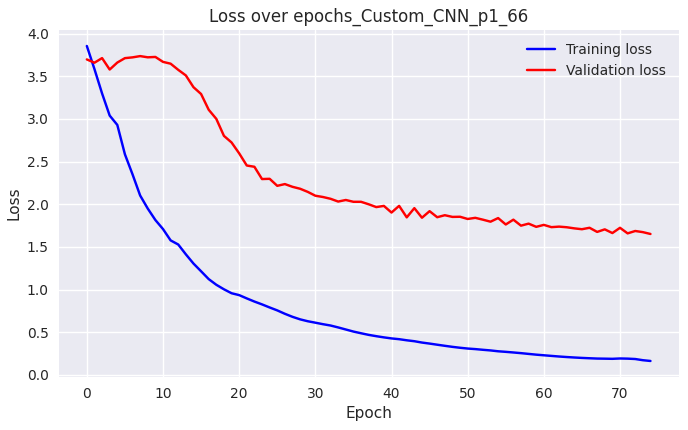

In [ ]:
# # Model 3 - Custom_CNN
train_model_with_all_params(Custom_CNN, ARTIFACT_SET_N, params_cnn, train_dataset, validation_dataset, 'Custom_CNN', 'p1')

## Treino e validação de raridade de artefato

In [ ]:
train_dataset, validation_dataset, X_train, y_train, X_validate, y_validate = define_train_dataset(drive_path_train_by_rarity, drive_path_validate_by_rarity)
# print(train_dataset)
# print(validation_dataset)

In [ ]:
# # Model 2 - VGG_mini
# current_id = train_model_with_all_params(VGG_mini, RARITY_N, params_cnn_2, train_dataset, validation_dataset, 'VGG_mini', 'p2')

In [ ]:
CNN_LEARNING_RATES_2 = [1e-4]
BATCH_SIZES_2 = [13]
N_EPOCHS_2 = [20]
CRITERIONS_2 = [
    loss_functions['nn.CrossEntropyLoss'],
]
OPTIMIZERS_2 = [
    optimizers['torch.optim.Adam'],
]
params_cnn_2 = list(itertools.product(
    CNN_LEARNING_RATES_2, BATCH_SIZES_2, N_EPOCHS_2, CRITERIONS_2, OPTIMIZERS_2
))

In [ ]:
# # Model 3 - Custom_CNN
# current_id = train_model_with_all_params(Custom_CNN, RARITY_N, params_cnn_2, train_dataset, validation_dataset, 'Custom_CNN', 'p2')

# Treino e validação com a rede SOM

## Treino e validação de conjunto de artefato

## Treino e validação de raridade de artefato